# Perform image tagging with pollen-vision

Learn how to perform image tagging with the pollen-vision library, using RAM++.

This notebook will show you how to use our wrapper for the RAM++ image tagging model developped by Xinyu Huang et al. at the Oppo research institute.

## A word on RAM++

RAM stands for Recognize Anything Model. RAM is an image tagging model which can recognize any common category of object with high accuracy. RAM++ is the newest generation of RAM which can now also perform zero shot image tagging. This means that the model is able to tag images with any object, considering you provide it with a description of the object.

This is very useful for us in Robotics because we can include this in applications to adapt the robot behavior depending of its environment. For example if we ask the robot to try to grasp a mug, it can first check whether there is a mug to grasp or not and if not perform another behavior.

You can find the RAM++ paper [here](https://arxiv.org/abs/2310.15200). Our wrapper for RAM uses [its implementation](https://github.com/xinyu1205/recognize-anything?tab=readme-ov-file) for the authors of the paper, credits to them!

## Use the RAM wrapper

In [1]:
import numpy as np
from PIL import Image

from pollen_vision.vision_models.object_detection import RAM_wrapper

To use pollen-vision's RAM wrapper, you just need to provide a description file. We provided a description file with a few basic objects if you want to try with it.

In [2]:
wrapper = RAM_wrapper(objects_descriptions_filename="example_objects_descriptions")

Creating pretrained CLIP model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.79it/s]


--------------
/home/simsim/Pollen/ai-dev/vision/pollen-vision/pollen_vision/checkpoints/ram_plus_swin_large_14m.pth
--------------
load checkpoint from /home/simsim/Pollen/ai-dev/vision/pollen-vision/pollen_vision/checkpoints/ram_plus_swin_large_14m.pth
vit: swin_l


The object classes that RAM can tag with the configuration file that you provided at the instanciation of the master can be checked with the *open_set_categories* attribute.

In [3]:
print(wrapper.open_set_categories)

['mug', 'bottle', 'fork', 'drawer', 'laptop', 'chair', 'lamp', 'sponge', 'sink', 'humanoid robot']


Import the image you want to perform the inference on. 

Here we will take one of the test image of the project where Reachy tries to serve a croissant, a French pastry made from puff pastry in a crescent shape, yummy!

We placed the demo images in sub folder in the images folder. Each subfolder is for a different situation where we recorded what Reachy was doing using teleoperation. Feel free to try with your own image!

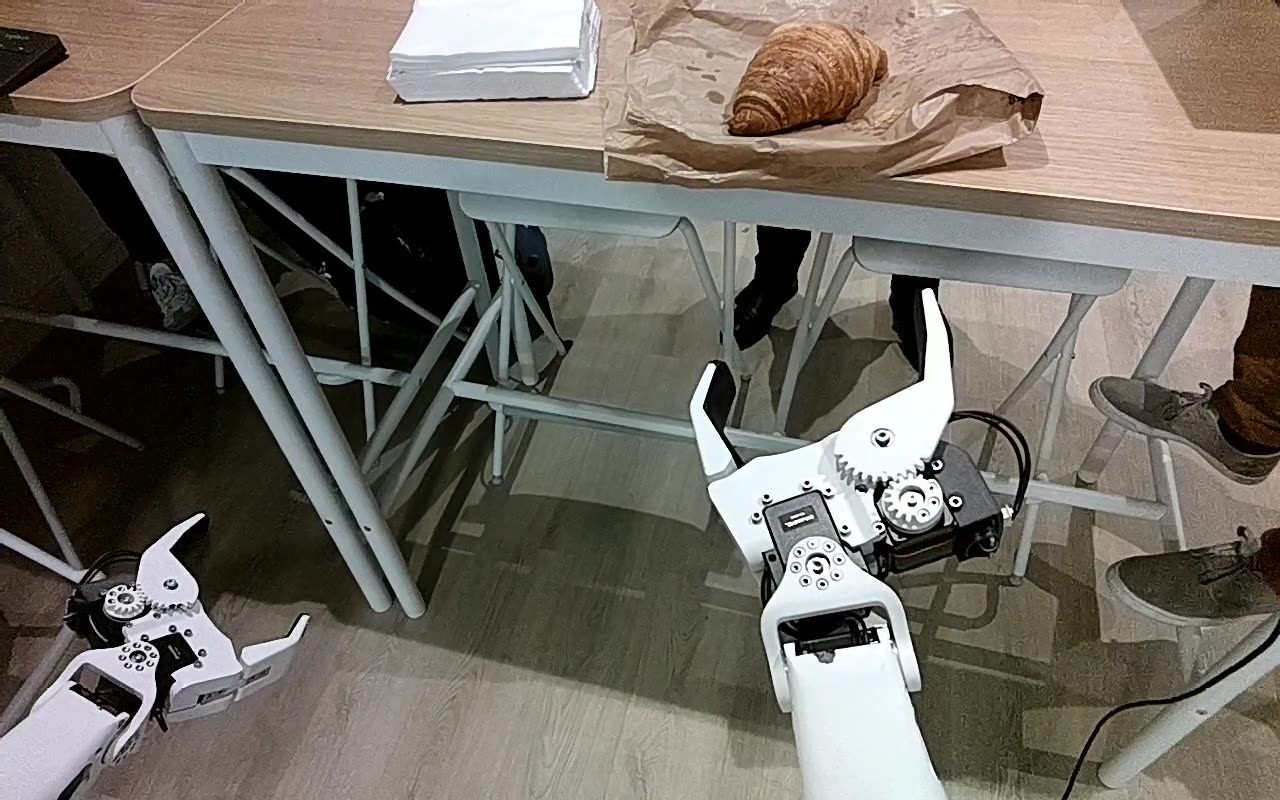

In [5]:
img = Image.open('images/croissant/croissant_01.jpg')
img

In [5]:
wrapper.infer(np.array(img))

['chair', 'humanoid robot']

So here, based on the objects our current RAM wrapper can tag, only two objects are considered to be in the frame: a humanoid robot and some chairs. But what if we want our wrapper to tag whether a croissant is in the image or not (to start a croissant grasping task for example)? 

## Generate a new description file

You can easily generate a new description file using pollen-vision with other objects that you want to tag. This file can then be used by the RAM wrapper.

In [18]:
from pollen_vision.vision_models.object_detection import ObjectDescriptionGenerator

💡 Please note that you will need an OpenAI API key for this as the generator uses the GPT 3.5 model to perform the generation.
By default the ObjectDetectionGenerator object looks at init for the API key defined with the **OPENAI_API_KEY** environment variable. If you prefer, you can just pass your API key as argument of the init with the *api_key* argument. 

In [19]:
object_detection_generator = ObjectDescriptionGenerator()

Just call the *generate_descriptions* method to generate the discription for the objects you want. Pass a list of objects names as argument. Here we will ask to generate descriptions for our croissant.

In [20]:
new_objects_list = ["croissant"]

objects_descriptions = object_detection_generator.generate_descriptions(objects=new_objects_list, generation_nb_per_object=30)

By default, 10 descriptions are generated per object. This can be changed with the optional argument *generation_nb_per_object* of the *generate_descriptions* method. Because a croissant can be a bit technical to tag, we asked for more description per object.

In [21]:
print(objects_descriptions)

{
    "croissant": [
        "A croissant is a crescent-shaped pastry that looks like a flaky, golden-brown crescent moon.",
        "You can identify a croissant by its crescent shape, flaky texture, and golden-brown color.",
        "A croissant looks like a buttery, flaky pastry with a crescent shape, often with a golden-brown exterior.",
        "The identifying characteristics of a croissant include its crescent shape, flaky layers, and buttery aroma.",
        "A croissant has a distinctive crescent shape, flaky layers, and a golden-brown, buttery exterior.",
        "When identifying a croissant, look for its crescent shape, flaky texture, and buttery aroma.",
        "The visual characteristics of a croissant include its crescent shape, golden-brown color, and flaky layers.",
        "You can recognize a croissant by its distinctive crescent shape, flaky layers, and buttery flavor.",
        "A croissant appears as a crescent-shaped, flaky pastry with a golden-brown exterior.",

You can save the descriptions you just generated to a json file that you can later use with RAM using the *save_descriptions* method. The description file will be saved in the object_descriptions folder.

In [22]:
object_detection_generator.save_descriptions(descriptions=objects_descriptions, descriptor_file_name='croissant-descriptor')

Descriptions saved to /home/simsim/Pollen/ai-dev/vision/pollen-vision/pollen_vision/pollen_vision/vision_models/object_detection/recognize_anything/objects_descriptions/croissant-descriptor.json


You can then use the description file you just generated with RAM.

In [2]:
my_new_ram_wrapper = RAM_wrapper(objects_descriptions_filename='croissant-descriptor')

Creating pretrained CLIP model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


--------------
/home/simsim/Pollen/ai-dev/vision/pollen-vision/pollen_vision/checkpoints/ram_plus_swin_large_14m.pth
--------------
load checkpoint from /home/simsim/Pollen/ai-dev/vision/pollen-vision/pollen_vision/checkpoints/ram_plus_swin_large_14m.pth
vit: swin_l


Let's check the objects our new wrapper is able to tag, to make sure if it can tag croissants

In [3]:
my_new_ram_wrapper.open_set_categories

['croissant']

Let's perform the image tagging with the same image as before.

In [7]:
my_new_ram_wrapper.infer(np.array(img))

['croissant']

Yes, apparently there is a croissant in the image!

Let's try to tag on a another image where there is no croissant, just to check if the tag actually works and does not tag a croissant on any image.

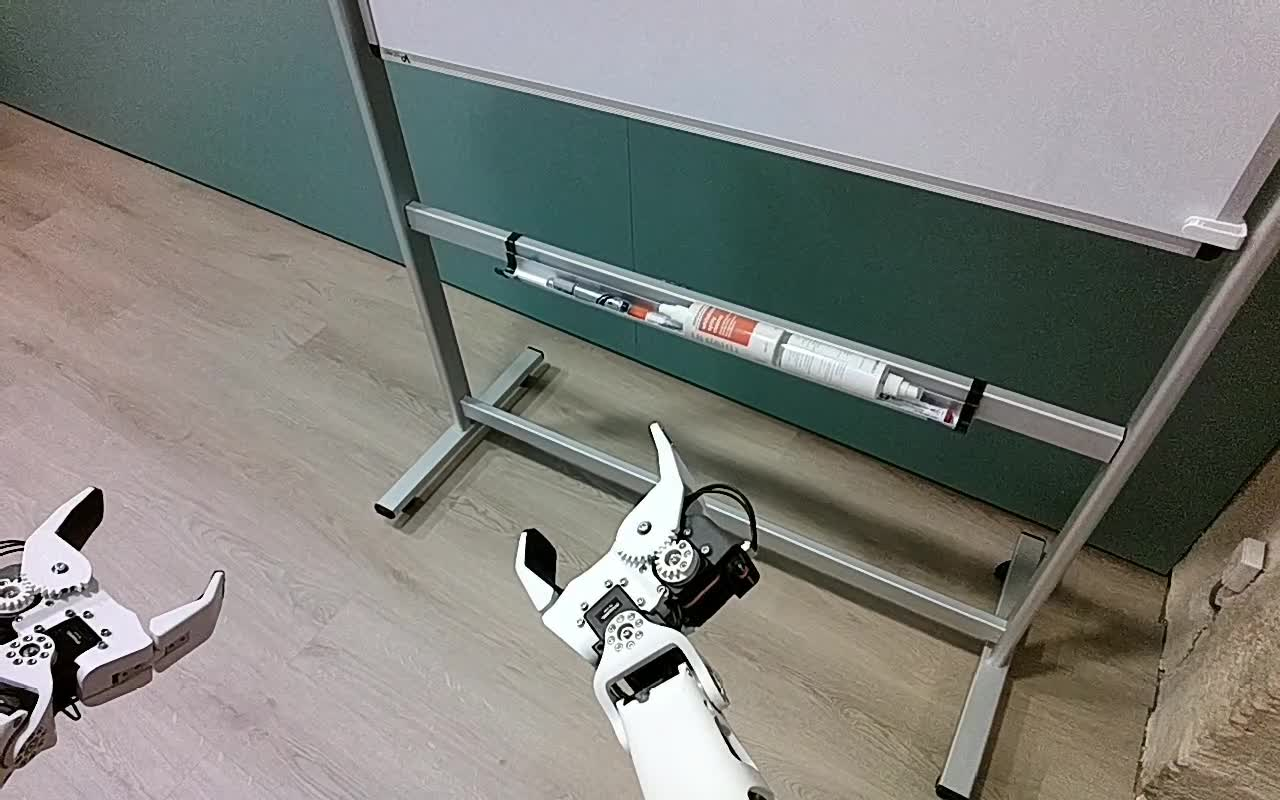

In [8]:
non_croissant_img = Image.open('images/whiteboard/whiteboard_01.jpg')
non_croissant_img

In [9]:
my_new_ram_wrapper.infer(np.array(non_croissant_img))

['']

Nice, the croissant tagging seems to work!